In [1]:
# clone it in the first time.
# !git clone -b functions_L2 https://github.com/kiranvad/geomstats.git

Follow the process in your terminal:

``cd geomstats``     
``pip3 install .``

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler

import geomstats.backend as gs
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.functions import HilbertSphere

INFO: Using numpy backend


# Simulated Data

In [3]:
data = pd.read_csv('simulated_data.csv')
data = data.iloc[:,1:101]

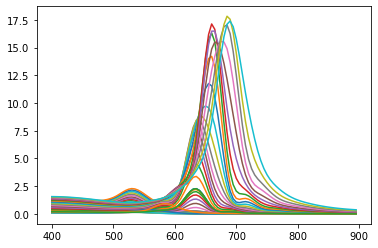

In [4]:
for i in range(len(data)):
    plt.plot(np.arange(400, 900, 5), data.iloc[i,:])
plt.show()

INFO: n_iter: 32, final variance: 0.430598496972086, final dist: [0.03675492], final_step_size: 1e-06


Projection data shape :  (53, 100)


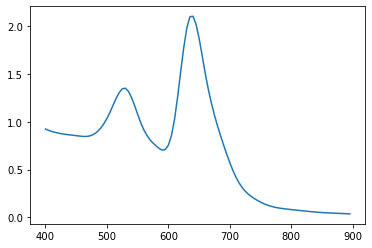

In [5]:
im = np.array(data)

manifold = HilbertSphere(np.arange(400, 900, 5))
sinf_data = gs.array([manifold.projection(si) for si in im]).squeeze()
print('Projection data shape : ', sinf_data.shape)
# compute the mean value
mean = FrechetMean(metric=manifold.metric, 
                   method="adaptive", 
                   max_iter=32, 
                   verbose=True)
mean.fit(sinf_data)
mean_estimate = mean.estimate_
fig, ax = plt.subplots()
ax.plot(np.arange(400, 900, 5), mean_estimate.flatten())
plt.show()

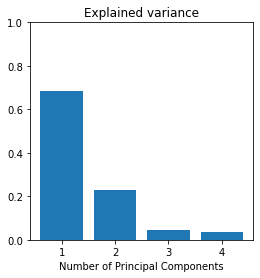

In [6]:
N_COMPONENTS = 4
tpca = TangentPCA(metric=manifold.metric, n_components=N_COMPONENTS)
tpca.fit(sinf_data, base_point=mean_estimate)
tangent_projected_data = tpca.transform(sinf_data)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
xticks = gs.arange(1, tpca.components_.shape[0] + 1, 1)
ax.xaxis.set_ticks(xticks)
ax.set_title("Explained variance")
ax.set_xlabel("Number of Principal Components")
ax.set_ylim((0, 1))
ax.bar(xticks, tpca.explained_variance_ratio_)
plt.show()

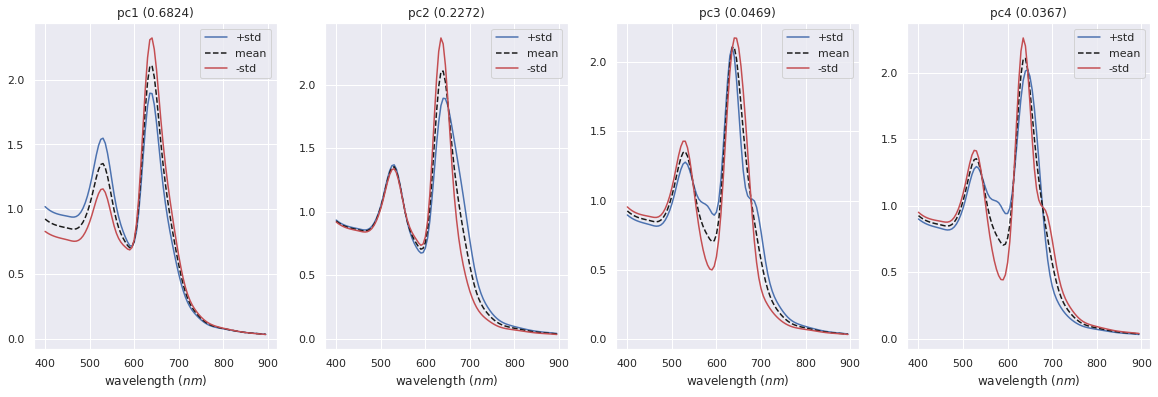

In [7]:
sns.set_theme()
fig,ax=plt.subplots(1,4,figsize=(20,6))
col=['r','k','b']
for i in range(4):
    ax[i].plot(np.arange(400, 900, 5), mean_estimate.flatten()+tpca.components_[i,:], label='+std', c=col[2])
    ax[i].plot(np.arange(400, 900, 5), mean_estimate.flatten(), label='mean', c=col[1], ls='--')
    ax[i].plot(np.arange(400, 900, 5), mean_estimate.flatten()-tpca.components_[i,:], label='-std', c=col[0])
    ax[i].set_title(f'pc{i+1} ({tpca.explained_variance_ratio_[i].round(4)})')
    ax[i].set_xlabel('wavelength $(nm)$',fontsize='12');
    ax[i].legend()

# UVVIS

In [ ]:
# !pip3 install --quiet zenodo_get
# !zenodo_get 10.5281/zenodo.6293330
# !mkdir data_uvvis
# !unzip Data_Share.zip -d data_uvvis >/dev/null

In [14]:
!pip install --quiet fdasrsf

In [17]:
import pickle
import pdb

plt.rcParams.update({"text.usetex": False,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

import sys, os
data_dir = './data_uvvis/Data_Share/Data/2021_12_30_Prepared_UV_Vis_Data'
peptides = ['MZ2', 'MZ2R', 'Z2', 'PZ2', 'Z2M6I', 'Z2M246I', 'AG3']

import fdasrsf as FDA

In [18]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

SI = pd.read_csv(data_dir + '/4x4x4_SI.csv', index_col=0)
peptides = SI['peptide_name'].value_counts().index.to_list()
print(peptides)

class UVVis:
    def __init__(self, name, scale=True):
        self.name = name
        self.df = SI[SI['peptide_name']==self.name]
        self.df.reset_index(drop=True, inplace=True)
        self.wav = self.wavelength()
        self.wavindx = np.logical_and(self.wav>=400, self.wav<=900)
        self.wav = self.wav[self.wavindx]
        self.dspace = self.get_dspace()
        self.scale = scale
        self._X()

    def _X(self):
        X = []
        for row, item in self.df.iterrows():
            uid = item['UID']
            data = pd.read_csv(data_dir+'/%s.txt'%uid, sep=',')
            x = data['subtracted_absorbance'][self.wavindx]
            if self.scale:
                x = minmax_scale(x)
            X.append(x)
            
        self.X = np.asarray(X)

    def __getitem__(self,i):
        return self.X[i,:], self.dspace[i,:]
    
    def __len__(self):
        return len(self.X)
    
    def shape(self):
        return self.X.shape
    
    def wavelength(self):
        uid = self.df.loc[0,'UID']
        data = pd.read_csv(data_dir+'/%s.txt'%uid, sep=',')
        wav = data['wavelength'].to_numpy()
        
        return wav
    
    def get_dspace(self):
        coords = self.df.loc[:,['peptide','HAuCl4','hepes']].to_numpy()
        scaled = []
        self.encoders = {}
        for i,col in enumerate(coords.T):
            le = LabelEncoder()
            scaled.append(le.fit_transform(col))
            self.encoders[i] = le
            
        scaled_coords = np.asarray(scaled).T
        
        return scaled_coords

    def level_to_conc(self, c):
        conc = []
        for i,ci in enumerate(c):
            conc.append(self.encoders[i].inverse_transform([ci]))
        
        return conc

    def savez(self,fname=None):
        if fname is None:
            fname = '../data/%s.npz'%self.name
        np.savez(fname,self.X,self.dspace()[0],self.wav)

['MZ2', 'MZ2R', 'Z2', 'PZ2', 'Z2M6I', 'Z2M246I', 'AG3']


In [19]:
X = []
for i, peptide in enumerate(peptides):
    data = UVVis(peptide, scale=False)
    Xp = data.X
    X.append(Xp)
X = np.vstack(X) # intensity values of UV-Vis spectra along the rows
grid_points = data.wav # wavelength sampling, same for all the spectra

print('Data matrix shape: ', X.shape)
print('Grid points shape: ', grid_points.shape)

Data matrix shape:  (448, 101)
Grid points shape:  (101,)


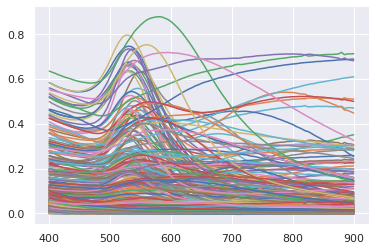

In [28]:
for i in range(len(X)):
    plt.plot(grid_points, X[i,:])
plt.show()

INFO: n_iter: 20, final variance: 0.6183639353669845, final dist: [0.02855179]


Projection data shape :  (448, 101)


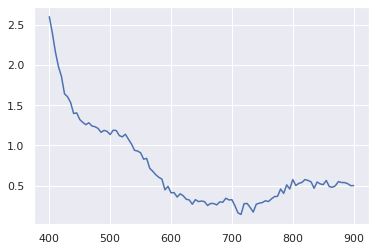

In [54]:
ix = np.array(X)

manifold = HilbertSphere(grid_points)
sinf_data = gs.array([manifold.projection(si) for si in ix]).squeeze()
print('Projection data shape : ', sinf_data.shape)
# compute the mean value
mean = FrechetMean(metric=manifold.metric, 
                   method="batch", 
                   max_iter=20, 
                   verbose=True)
mean.fit(sinf_data)
mean_estimate = mean.estimate_
fig, ax = plt.subplots()
ax.plot(grid_points, mean_estimate.flatten())
plt.show()

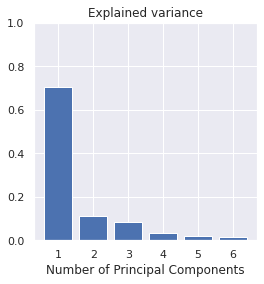

In [55]:
N_COMPONENTS = 6
tpca = TangentPCA(metric=manifold.metric, n_components=N_COMPONENTS)
tpca.fit(sinf_data, base_point=mean_estimate)
tangent_projected_data = tpca.transform(sinf_data)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
xticks = gs.arange(1, tpca.components_.shape[0] + 1, 1)
ax.xaxis.set_ticks(xticks)
ax.set_title("Explained variance")
ax.set_xlabel("Number of Principal Components")
ax.set_ylim((0, 1))
ax.bar(xticks, tpca.explained_variance_ratio_)
plt.show()

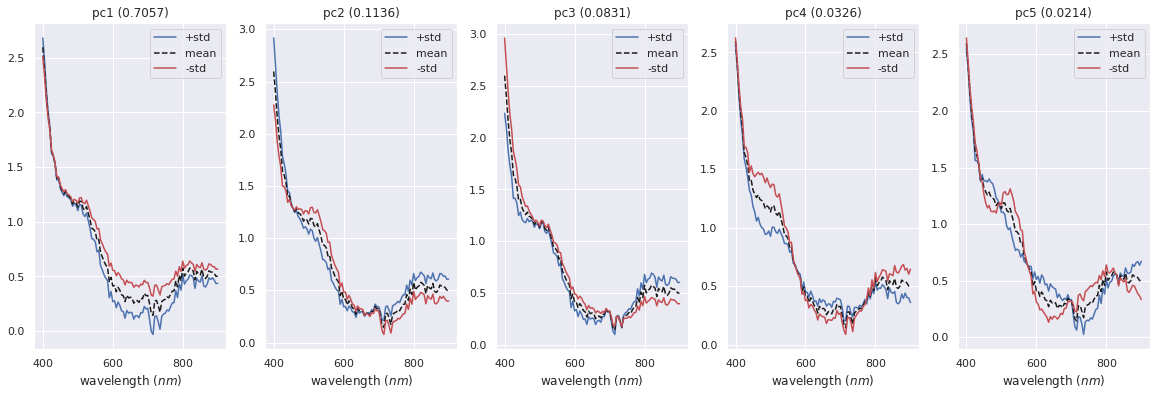

In [57]:
sns.set_theme()
fig,ax=plt.subplots(1,5,figsize=(20,6))
col=['r','k','b']
for i in range(5):
    ax[i].plot(grid_points, mean_estimate.flatten()+tpca.components_[i,:], label='+std', c=col[2])
    ax[i].plot(grid_points, mean_estimate.flatten(), label='mean', c=col[1], ls='--')
    ax[i].plot(grid_points, mean_estimate.flatten()-tpca.components_[i,:], label='-std', c=col[0])
    ax[i].set_title(f'pc{i+1} ({tpca.explained_variance_ratio_[i].round(4)})')
    ax[i].set_xlabel('wavelength $(nm)$',fontsize='12');
    ax[i].legend()